In [12]:
import numpy as np
import math
from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [13]:
H = math.sqrt(0.5)*np.array([1,1,1,-1]).reshape(2,2)
X = np.array([0,1,1,0]).reshape(2,2)
Y = np.array([0,-1j,1j,0]).reshape(2,2)
Z = np.array([1,0,0,-1]).reshape(2,2)
U = np.linalg.eig(H)[1].conj().T

CZ = np.eye(4)
CZ[3][3] = -1
CCZ = np.eye(8)
CCZ[7][7] = -1

U1 = np.kron(np.kron(X,U),np.eye(2))
V1 = CCZ
U1_ = U1.conj().T

U2 = np.kron(np.kron(X,U),np.eye(2))
V2 = np.kron(CZ,np.eye(2))
U2_ = U2.conj().T


U3 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V3 = np.kron(np.eye(2),CZ)
U3_ = U3.conj().T

U4 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V4 = np.kron(CZ,np.eye(2)) @ np.kron(np.eye(2),CZ)
U4_ = U4.conj().T

U5 = np.kron(np.kron(np.eye(2),X @ U),np.eye(2))
V5 = CCZ
U5_ = U5.conj().T

J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

[[0.     +0.j 0.1385 +0.j 0.00148+0.j]
 [0.     +0.j 0.     +0.j 0.01304+0.j]
 [0.     +0.j 0.     +0.j 0.     +0.j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.t

distance: 1.742355 ; time: 752.06
distance: 2.627477 ; time: 814.76
distance: 1.38828 ; time: 705.26
distance: 4.040757 ; time: 552.54
distance: 2.049387 ; time: 739.55
distance: 7.311174 ; time: 824.69
distance: 0.997853 ; time: 556.83
distance: 2.745374 ; time: 657.47
distance: 4.790171 ; time: 684.25
distance: 3.743785 ; time: 639.1
distance: 0.49445 ; time: 625.78
distance: 4.099149 ; time: 672.46
distance: 1.516824 ; time: 492.66
distance: 2.017824 ; time: 598.21
distance: 6.770643 ; time: 537.21
distance: 1.096343 ; time: 794.23
distance: 4.008131 ; time: 795.11
distance: 2.41322 ; time: 435.24
distance: 3.441939 ; time: 576.12
distance: 1.450066 ; time: 424.49
distance: 1.482257 ; time: 520.68
distance: 2.278471 ; time: 610.79
distance: 3.007174 ; time: 484.17
distance: 1.217504 ; time: 677.52
distance: 3.102946 ; time: 666.88
distance: 4.510243 ; time: 711.79
distance: 3.010925 ; time: 611.54
distance: 4.424309 ; time: 678.61
distance: 1.07716 ; time: 584.15
distance: 7.721094 

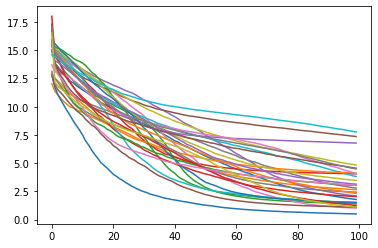

In [22]:
n = 30
m = 100
k = 6

descents = [GradientDescent(V2, k) for _ in range(n)]

for descent in descents:
    descent.noise = 1
    descent.randomize_params()
    descent.set_j(J)

print(descents[0].gates[1].j)

losses = [descent.descend(steps=m, track_distance=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss))
for descent in descents:
    descent.make_times_positive()
    print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))

In [23]:
descent = descents[10]
descent.distance

(0.49444969469899824+0j)

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


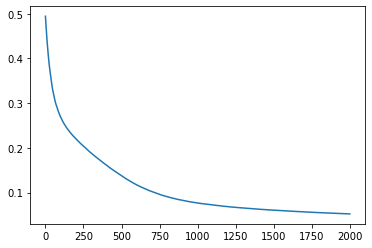

In [24]:
loss = descent.descend(steps=2000, track_distance=True)
plt.plot(np.real(loss))

In [25]:
print(descent.time)
descent.to_text("./Oleg/V2.txt")

625.1178011626578
